From the beginning, since the first printed newspaper, every news that makes into a page has had a specific section allotted to it. Although pretty much everything changed in newspapers from the ink to the type of paper used, this proper categorization of news was carried over by generations and even to the digital versions of the newspaper. Newspaper articles are not limited to a few topics or subjects, it covers a wide range of interests from politics to sports to movies and so on. For long, this process of sectioning was done manually by people but now technology can do it without much effort. In this hackathon, Data Science and Machine Learning enthusiasts like you will use Natural Language Processing to predict which genre or category a piece of news will fall in to from the story.

# FEATURES:

## STORY:  A part of the main content of the article to be published as a piece of news.
## SECTION: The genre/category the STORY falls in.

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :

* Politics: 0
* Technology: 1
* Entertainment: 2
* Business: 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk import word_tokenize, pos_tag, pos_tag_sents
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("TrainDataset.csv")
df_predict = pd.read_csv("TestDataset.csv")

In [3]:
df.head(10)

,STORY,SECTION
0,The roadshow and the filing of nomination pape...,0
1,These vulnerabilities could have allowed hacke...,1
2,"""People will now be able to include music in t...",1
3,Jersey is expected to have a good start at the...,2
4,Xiaomi’s unveiling also hints at how Samsung i...,1
5,Analysts at Edelweiss Securities Ltd point out...,3
6,The directorial debut of Prithviraj Sukumaran ...,2
7,"Chrome is the most popular web browser, with a...",1
8,"""Maruti saw a sudden turn in its stock price a...",3
9,Centrum has also raised TCS target prices high...,3


In [62]:
df_predict.head(10)

,STORY
0,Privileged to have done this candid and COMPLE...
1,6) Some analysts expect volatility to remain h...
2,There is no stopping Marvel Cinematic Universe...
3,"According to Ravi Menon, analyst at Elara Secu..."
4,"A complaint against Nadiadwala, known for prod..."
5,”The yet-to-be-titled movie marks Mahesh’s 26t...
6,"Gandhi, also in Raichur with former PM H.D.Dev..."
7,It’s clear that at the heart of this inspiring...
8,Other features of the Realme 3 include a tripl...
9,The couple’s lawyers had asked for a bifurcate...


In [64]:
df_predict.count()

STORY    1526
dtype: int64

In [5]:
df.count()

STORY      6102
SECTION    6102
dtype: int64

In [6]:
df.isnull().sum()

STORY      0
SECTION    0
dtype: int64

In [7]:
df_predict.isnull().sum()

STORY    0
dtype: int64

In [8]:
section_count = df.groupby('SECTION')
print("total categories:", section_count.ngroups)
print(section_count.size())

total categories: 4
SECTION
0    1341
1    2224
2    1524
3    1013
dtype: int64


As we see here, 
1. Political: 1341
2. Technology: 2224
3. Entertainment: 1524
4. Business: 1013

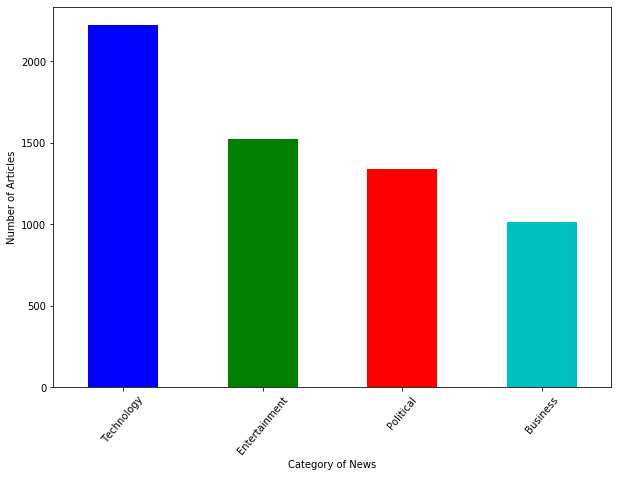

In [9]:
plt.figure(figsize=(10,7))
cmapper = ['b', 'g', 'r', 'c']
bars = ('Technology', 'Entertainment', 'Political', 'Business')
y_pos = np.arange(len(bars))
df['SECTION'].value_counts().sort_values(ascending=False).plot.bar(color=cmapper)
plt.xticks(rotation=50)
plt.xlabel("Category of News")
plt.ylabel("Number of Articles")
plt.xticks(y_pos, bars)
plt.show()

In [10]:
type(df)

pandas.core.frame.DataFrame

## Pre-processing

##### Finding Out word Count of each row and calculating average depeding on the category of news

In [11]:
df['TotalWords'] = df['STORY'].apply(lambda x: len(str(x).split(" ")))

In [12]:
df['TotalWords']

0       152
1       176
2        92
3        34
4       124
       ... 
6097     33
6098    121
6099     23
6100     44
6101    223
Name: TotalWords, Length: 6102, dtype: int64

In [13]:
avg_word_count = df.groupby('SECTION')['TotalWords'].mean()

In [14]:
avg_word_count

SECTION
0    143.903803
1    117.781475
2     60.672572
3     97.822310
Name: TotalWords, dtype: float64

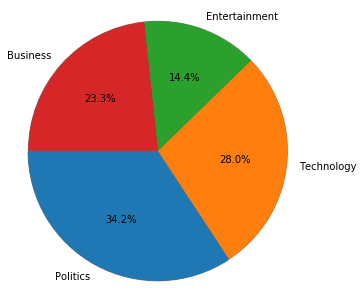

In [15]:
labels = 'Politics', 'Technology', 'Entertainment', 'Business'
sizes = avg_word_count
theme = plt.get_cmap('bwr')
fig1, ax1 = plt.subplots()
fig1.subplots_adjust(0.3,0,1,1)
explode = (0.9, 0, 0, 0)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=900, radius=200)
ax1.axis('equal') 
plt.show()

###### As we see here, Politics news has the longest story on an average followed by technology and business respectively.

## Converting all strings to lowercase

In [16]:
df['STORY']=df['STORY'].str.lower()

In [17]:
df['STORY'].head()

0    the roadshow and the filing of nomination pape...
1    these vulnerabilities could have allowed hacke...
2    "people will now be able to include music in t...
3    jersey is expected to have a good start at the...
4    xiaomi’s unveiling also hints at how samsung i...
Name: STORY, dtype: object

The idea behind converting all string to lower case is, in NLP words with capital letters hold different weightage to all lower case. Which overall makes your NLP model less effective or inaccurate

## Checking if there are any Numeric values

In [18]:
sum(df['STORY'].str.isnumeric())

0

We checked if there are any numerical values, to filter it, because it does not contribute to the model
***
## Checking if there are any Punctuation Marks

In [19]:
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
df['P_count'] = df.STORY.map(lambda v: any(x in v for x in punctuation))

In [20]:
sum(df['P_count'])

5983

Out of 6102 records, 5982 records have punctuation marks. Its recommended to remove punctuation marks in order to improve efficiency of the model

In [21]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df["STORY"] = df['STORY'].apply(remove_punctuations)
df['STORY'] = df['STORY'].str.replace('[^\w\s]','')

In [22]:
df["STORY"]

0       the roadshow and the filing of nomination pape...
1       these vulnerabilities could have allowed hacke...
2       people will now be able to include music in th...
3       jersey is expected to have a good start at the...
4       xiaomis unveiling also hints at how samsung is...
                              ...                        
6097    based on the video game franchise of the same ...
6098    the seven states have been neglected for decad...
6099    shanthnu made the announcement on twitter and ...
6100    the rock and jason statham reprise their roles...
6101    but unlike past developments that never caught...
Name: STORY, Length: 6102, dtype: object

##### Final Check

In [23]:
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
df['P_count'] = df.STORY.map(lambda x: any(char in x for char in punctuation))
sum(df['P_count'])

0

***
## Remove whitespaces

In [24]:
df["STORY"] = df['STORY'].str.strip()

In [25]:
df["STORY"]

0       the roadshow and the filing of nomination pape...
1       these vulnerabilities could have allowed hacke...
2       people will now be able to include music in th...
3       jersey is expected to have a good start at the...
4       xiaomis unveiling also hints at how samsung is...
                              ...                        
6097    based on the video game franchise of the same ...
6098    the seven states have been neglected for decad...
6099    shanthnu made the announcement on twitter and ...
6100    the rock and jason statham reprise their roles...
6101    but unlike past developments that never caught...
Name: STORY, Length: 6102, dtype: object

***
## Removing Stop Words
Stop words like "the", "and", "a" and many more make it difficult for the algorithmn to understand, hence it is better if it is suggested to remove these words and make records more meaningful

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saurabhkolambkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
df['STORY'] = df['STORY'].apply(lambda s: " ".join(s for s in s.split() if s not in stop_words)) 
df['STORY']

0       roadshow filing nomination papers also attempt...
1       vulnerabilities could allowed hackers access s...
2       people able include music videos facebook inst...
3       jersey expected good start box office attentio...
4       xiaomis unveiling also hints samsung starting ...
                              ...                        
6097    based video game franchise name sonic hedgehog...
6098    seven states neglected decades sends onetwo me...
6099    shanthnu made announcement twitter shared pict...
6100    rock jason statham reprise roles fast furious ...
6101    unlike past developments never caught 3d tvs a...
Name: STORY, Length: 6102, dtype: object

***
## Sometimes stop words aren't enough to clean data. So it would be better to remove extremely rare and common words


In [29]:
from collections import Counter
Counter(" ".join(df["STORY"]).split()).most_common(50)

[('said', 2880),
 ('also', 2132),
 ('new', 1563),
 ('india', 1455),
 ('congress', 1340),
 ('bjp', 1244),
 ('one', 1190),
 ('party', 1128),
 ('year', 1097),
 ('like', 1087),
 ('people', 1012),
 ('would', 967),
 ('last', 923),
 ('first', 920),
 ('two', 910),
 ('us', 888),
 ('time', 882),
 ('data', 844),
 ('users', 838),
 ('elections', 807),
 ('smartphone', 773),
 ('government', 762),
 ('minister', 752),
 ('modi', 741),
 ('market', 738),
 ('may', 707),
 ('even', 689),
 ('company', 680),
 ('lok', 663),
 ('sabha', 663),
 ('state', 662),
 ('years', 630),
 ('apple', 625),
 ('film', 621),
 ('seats', 608),
 ('according', 603),
 ('million', 579),
 ('election', 575),
 ('three', 565),
 ('could', 557),
 ('since', 548),
 ('app', 542),
 ('facebook', 534),
 ('political', 533),
 ('back', 531),
 ('chief', 526),
 ('indian', 526),
 ('google', 520),
 ('made', 507),
 ('pro', 503)]

In [30]:
selected_words = ['said','also','new','like','u','say']
df['STORY'] = df['STORY'].apply(lambda x: " ".join(x for x in x.split() if x not in selected_words)) 
df['STORY']

0       roadshow filing nomination papers attempt show...
1       vulnerabilities could allowed hackers access s...
2       people able include music videos facebook inst...
3       jersey expected good start box office attentio...
4       xiaomis unveiling hints samsung starting lose ...
                              ...                        
6097    based video game franchise name sonic hedgehog...
6098    seven states neglected decades sends onetwo me...
6099    shanthnu made announcement twitter shared pict...
6100    rock jason statham reprise roles fast furious ...
6101    unlike past developments never caught 3d tvs a...
Name: STORY, Length: 6102, dtype: object

In [31]:
low_count = pd.Series(' '.join(df['STORY']).split()).value_counts()[-50:]
low_count

5647332            1
fatehi             1
1297               1
mithi              1
bambas             1
kandasamy          1
nitesh             1
tacitly            1
dayma              1
sonipurnima        1
adan               1
discerning         1
reconfigurable     1
bnps               1
tomboyish          1
8000090000         1
elopement          1
teale              1
7646               1
numberswhatsapp    1
jps                1
connectors         1
fuzzier            1
lokpal             1
microstrategist    1
aashwasana         1
hewlettpackard     1
jerseymehandi      1
westeross          1
001mm              1
macedonia          1
tejananthkumar     1
whisper            1
142                1
jerseymy           1
nadella            1
motioncontrol      1
1408               1
jayantsinha        1
bharatbharat       1
khaleda            1
collectives        1
mash               1
characteri         1
intergalactic      1
aiyaary            1
renewables         1
parikh       

In [32]:
selected_words = low_count
df['STORY'] = df['STORY'].apply(lambda x: " ".join(x for x in x.split() if x not in selected_words)) 
df['STORY']

0       roadshow filing nomination papers attempt show...
1       vulnerabilities could allowed hackers access s...
2       people able include music videos facebook inst...
3       jersey expected good start box office attentio...
4       xiaomis unveiling hints samsung starting lose ...
                              ...                        
6097    based video game franchise name sonic hedgehog...
6098    seven states neglected decades sends onetwo me...
6099    shanthnu made announcement twitter shared pict...
6100    rock jason statham reprise roles fast furious ...
6101    unlike past developments never caught 3d tvs a...
Name: STORY, Length: 6102, dtype: object

## Lemmatization Using lemminflect

In [33]:
from textblob import Word
from lemminflect import getLemma
df['STORY'] = df['STORY'].apply(lambda x: " ".join([Word(getLemma).lemmatize() for getLemma in x.split()]))
df['STORY']

0       roadshow filing nomination paper attempt show ...
1       vulnerability could allowed hacker access sens...
2       people able include music video facebook insta...
3       jersey expected good start box office attentio...
4       xiaomis unveiling hint samsung starting lose p...
                              ...                        
6097    based video game franchise name sonic hedgehog...
6098    seven state neglected decade sends onetwo memb...
6099    shanthnu made announcement twitter shared pict...
6100    rock jason statham reprise role fast furious f...
6101    unlike past development never caught 3d tv ana...
Name: STORY, Length: 6102, dtype: object

#### If you want to check the 2nd record which changed vulnerabilities  to vulnerability

## Tokenization

In [34]:
final = df_predict['STORY']
for i in final:
    w = nltk.sent_tokenize(i)
print(w)

['Producer Dil Raju and director Mohana Krishna Indraganti on Monday announced the title of their upcoming movie\n\n\n Interestingly, Sudheer and Aditi earlier shared screen space in Mohana Krishna Indraganti’s Sammohanam, while Nivetha Thomas made her Telugu screen debut with the director’s 2016 film Gentleman\n\n\nAsking fans to “except the unexpected”, Sudheer posted on Twitter, “V are coming back and this time with an action thriller']


## Vectorization

In [35]:
tf_vec = TfidfVectorizer(ngram_range=(1,2)) 

In [36]:
news_train = tf_vec.fit_transform(df.STORY).toarray()

In [37]:
news_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
story_df = df_predict['STORY']
news_pred = tf_vec.fit_transform(story_df).toarray()

In [39]:
news_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

***
## Model Building

In [40]:
X = df['STORY']
y = df['SECTION']

In [41]:
X_train , X_test ,y_train , y_test = train_test_split(X, y ,test_size = 0.2 ,random_state = 0) 

In [42]:
ct_vec = CountVectorizer()
tf_idf_tr = TfidfTransformer()

In [43]:
news_vec = ct_vec.fit_transform(X_train)
X_train_tf = tf_idf_tr.fit_transform(news_vec)
# X_test_tf = ct_vec.transform(X_train_tf)

## Logistic Regression

In [71]:
lr = LogisticRegression(random_state=100)
lr.fit(X_train_tf,y_train)
lr_xtest_pred = ct_vec.transform(X_test)
lr_ytest_pred = lr.predict(lr_xtest_pred)
lr_xtrain_pred = ct_vec.transform(X_train)
lr_ytrain_pred = lr.predict(lr_xtrain_pred)

In [45]:
lr_ytest_pred

array([1, 0, 1, ..., 2, 2, 1])

In [74]:
print('Report:\n',classification_report(y_test, lr_ytest_pred))
print('Confustion Matrix:\n',confusion_matrix(y_test,lr_ytest_pred))
lr_score = cross_val_score(lr, lr_xtest_pred, lr_ytest_pred, cv=5, scoring='f1_macro')
print('\nCross Validation:', lr_score.mean())
print("Accuracy: ", accuracy_score(y_test,lr_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(lr_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(lr_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(lr_score)*100)

Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       290
           1       0.95      0.96      0.96       432
           2       0.99      0.90      0.94       294
           3       0.93      0.98      0.96       205

    accuracy                           0.96      1221
   macro avg       0.96      0.96      0.96      1221
weighted avg       0.96      0.96      0.96      1221

Confustion Matrix:
 [[285   2   1   2]
 [  7 416   1   8]
 [  9  16 265   4]
 [  0   4   0 201]]

Cross Validation: 0.9370453791887204
Accuracy:  95.57739557739558 %
The Training data f1 Score is 0.9727514853513625
The Testing data f1 Score is 0.9557739557739557
Standard Deviation:  1.1979445008133258


## Random Forest

In [47]:
rfc = RandomForestClassifier(random_state = 100, n_jobs=-1)
rfc.fit(X_train_tf,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [75]:
gs_xtest_pred = ct_vec.transform(X_test)
gs_ytest_pred = rfc.predict(gs_xtest_pred)
gs_xtrain_pred = ct_vec.transform(X_train)
gs_ytrain_pred = rfc.predict(gs_xtrain_pred)

In [78]:
print('Report:\n',classification_report(y_test, gs_ytest_pred))
print('Confustion Matrix:\n',confusion_matrix(y_test,gs_ytest_pred))
gs_score = cross_val_score(rfc, gs_xtest_pred, gs_ytest_pred, cv=5, scoring='f1_macro')
print('\nCross Validation:', gs_score.mean())
print("Accuracy: ", accuracy_score(y_test,gs_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(gs_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(gs_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(gs_score)*100)

Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       290
           1       0.90      0.94      0.92       432
           2       0.91      0.92      0.92       294
           3       0.91      0.83      0.87       205

    accuracy                           0.91      1221
   macro avg       0.92      0.90      0.91      1221
weighted avg       0.91      0.91      0.91      1221

Confustion Matrix:
 [[270   8  11   1]
 [  5 404  10  13]
 [  9  13 270   2]
 [  3  26   5 171]]

Cross Validation: 0.846451472097949
Accuracy:  91.31859131859132 %
The Training data f1 Score is 0.9889366933005531
The Testing data f1 Score is 0.9131859131859131
Standard Deviation:  1.8156849184615698


## SVM

In [79]:
svm = LinearSVC()
svm.fit(X_train_tf,y_train)
svm_xtest_pred = ct_vec.transform(X_test)
svm_ytest_pred = svm.predict(svm_xtest_pred)
svm_xtrain_pred = ct_vec.transform(X_train)
svm_ytrain_pred = svm.predict(svm_xtrain_pred)

In [80]:
svm_ytest_pred

array([1, 0, 1, ..., 2, 2, 1])

In [81]:
print('Report:\n',classification_report(y_test, svm_ytest_pred))
print('Confustion Matrix:\n',confusion_matrix(y_test,svm_ytest_pred))
svm_score = cross_val_score(svm, svm_xtest_pred, svm_ytest_pred, cv=5, scoring='f1_macro')
print('Cross Validation:', svm_score.mean())
print("\n Accuracy: ", accuracy_score(y_test,svm_ytest_pred)*100,"%")
print('\nThe Training data f1 Score is', f1_score(svm_ytrain_pred, y_train,average='micro'))
print('\nThe Testing data f1 Score is', f1_score(svm_ytest_pred, y_test,average='micro'))
print("\nStandard Deviation: ",np.std(svm_score)*100)

Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       290
           1       0.95      0.97      0.96       432
           2       1.00      0.90      0.95       294
           3       0.93      0.97      0.95       205

    accuracy                           0.96      1221
   macro avg       0.96      0.96      0.96      1221
weighted avg       0.96      0.96      0.96      1221

Confustion Matrix:
 [[284   2   1   3]
 [  6 419   0   7]
 [  8  15 266   5]
 [  0   6   0 199]]
Cross Validation: 0.9304741367193639

 Accuracy:  95.65929565929567 %

The Training data f1 Score is 0.9934439664003278

The Testing data f1 Score is 0.9565929565929566

Standard Deviation:  1.3246770780861998


## KNN

In [82]:
knn = KNeighborsClassifier()
knn.fit(X_train_tf,y_train)
knn_xtest_pred = ct_vec.transform(X_test)
knn_ytest_pred = knn.predict(knn_xtest_pred)
knn_xtrain_pred = ct_vec.transform(X_train)
knn_ytrain_pred = knn.predict(knn_xtrain_pred)

In [83]:
knn_ytest_pred

array([1, 0, 1, ..., 2, 2, 1])

In [84]:
print('Report:\n',classification_report(y_test, knn_ytest_pred))
print('Confustion Matrix:\n',confusion_matrix(y_test,knn_ytest_pred))
knn_score = cross_val_score(knn, knn_xtest_pred, knn_ytest_pred, cv=5, scoring='f1_macro')
print('Cross Validation:', knn_score.mean())
print("\n Accuracy: ", accuracy_score(y_test,knn_ytest_pred)*100,"%")
print('\nThe Training data f1 Score is', f1_score(knn_ytrain_pred, y_train,average='micro'))
print('\nThe Testing data f1 Score is', f1_score(knn_ytest_pred, y_test,average='micro'))
print("\nStandard Deviation: ",np.std(knn_score)*100)

Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       290
           1       0.91      0.96      0.94       432
           2       0.99      0.88      0.93       294
           3       0.95      0.92      0.93       205

    accuracy                           0.93      1221
   macro avg       0.94      0.93      0.93      1221
weighted avg       0.94      0.93      0.93      1221

Confustion Matrix:
 [[278   9   1   2]
 [ 11 414   2   5]
 [ 16  15 260   3]
 [  2  15   0 188]]
Cross Validation: 0.5225042344145517

 Accuracy:  93.36609336609337 %

The Training data f1 Score is 0.9586150379020693

The Testing data f1 Score is 0.9336609336609336

Standard Deviation:  2.805322688679803


In [89]:
print("Logistic Regression")
print("Accuracy: ", accuracy_score(y_test,lr_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(lr_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(lr_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(lr_score)*100)
print("\nRandom Forest")
print("Accuracy: ", accuracy_score(y_test,gs_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(gs_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(gs_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(gs_score)*100)
print("\nSVM")
print("Accuracy: ", accuracy_score(y_test,svm_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(svm_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(svm_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(svm_score)*100)
print("\nKNN")
print("Accuracy: ", accuracy_score(y_test,knn_ytest_pred)*100,"%")
print('The Training data f1 Score is', f1_score(knn_ytrain_pred, y_train,average='micro'))
print('The Testing data f1 Score is', f1_score(knn_ytest_pred, y_test,average='micro'))
print("Standard Deviation: ",np.std(knn_score)*100)


Logistic Regression
Accuracy:  95.57739557739558 %
The Training data f1 Score is 0.9727514853513625
The Testing data f1 Score is 0.9557739557739557
Standard Deviation:  1.1979445008133258

Random Forest
Accuracy:  91.31859131859132 %
The Training data f1 Score is 0.9889366933005531
The Testing data f1 Score is 0.9131859131859131
Standard Deviation:  1.8156849184615698

SVM
Accuracy:  95.65929565929567 %
The Training data f1 Score is 0.9934439664003278
The Testing data f1 Score is 0.9565929565929566
Standard Deviation:  1.3246770780861998

KNN
Accuracy:  93.36609336609337 %
The Training data f1 Score is 0.9586150379020693
The Testing data f1 Score is 0.9336609336609336
Standard Deviation:  2.805322688679803


In [58]:
final_2 = ct_vec.transform(final)
predictions = lr.predict(final_2)

In [59]:
Solution= pd.DataFrame({'SECTION':predictions})

In [60]:
Solution.to_csv('prediction.csv',index=False)

In [61]:
len(Solution)

1526